In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import lightgbm as lgb

# Feature selection

In [3]:
training_data = pd.read_csv('training_set_VU_DM.csv') 

In [5]:
training_data['date_time'] = pd.to_datetime(training_data['date_time'])

training_data['Cin_hour'] = training_data["date_time"].apply(lambda x: x.hour)
training_data['Cin_day'] = training_data["date_time"].apply(lambda x: x.day)
training_data['Cin_month'] = training_data["date_time"].apply(lambda x: x.month)
training_data['Cin_quarter'] = training_data["date_time"].apply(lambda x: x.quarter)
training_data['Cin_day_of_week'] = training_data['date_time'].dt.dayofweek+1 #we don't want zeros

training_data.drop('date_time',axis=1,inplace=True)

In [6]:
training_data['priceRank'] = training_data.groupby('srch_id')['price_usd'].rank()
training_data['starRank'] = training_data.groupby('srch_id')['prop_starrating'].rank()
training_data['reviewRank'] = training_data.groupby('srch_id')['prop_review_score'].rank()
training_data['location1Rank'] = training_data.groupby('srch_id')['prop_location_score1'].rank()
training_data['location2Rank'] = training_data.groupby('srch_id')['prop_location_score2'].rank()
training_data['histpriceRank'] = training_data.groupby('srch_id')['prop_log_historical_price'].rank()

In [12]:
training_data['rating_diff']=abs(training_data['visitor_hist_starrating']-training_data['prop_starrating'])
training_data['rating_diff']=training_data['rating_diff'].fillna(training_data['rating_diff'].mean())

training_data['price_diff']=abs(training_data['visitor_hist_adr_usd']-training_data['price_usd'])
training_data['price_diff']=training_data['price_diff'].fillna(training_data['price_diff'].mean())

In [13]:
# creating new features
training_data['competitor_rate'] = (training_data.comp1_rate + training_data.comp2_rate + training_data.comp3_rate +
                                    training_data.comp4_rate + training_data.comp5_rate + training_data.comp6_rate +
                                    training_data.comp7_rate + training_data.comp8_rate)

training_data['competitor_inv'] = (training_data.comp1_inv + training_data.comp2_inv + training_data.comp3_inv +
                                    training_data.comp4_inv + training_data.comp5_inv + training_data.comp6_inv +
                                    training_data.comp7_inv + training_data.comp8_inv)

training_data['competitor_rpd'] = (  training_data.comp1_rate_percent_diff + training_data.comp2_rate_percent_diff
                                   + training_data.comp3_rate_percent_diff + training_data.comp4_rate_percent_diff
                                   + training_data.comp5_rate_percent_diff + training_data.comp6_rate_percent_diff
                                   + training_data.comp7_rate_percent_diff + training_data.comp8_rate_percent_diff) /8/100

training_data.drop('comp1_rate',axis=1,inplace=True)
training_data.drop('comp2_rate',axis=1,inplace=True)
training_data.drop('comp3_rate',axis=1,inplace=True)
training_data.drop('comp4_rate',axis=1,inplace=True)
training_data.drop('comp5_rate',axis=1,inplace=True)
training_data.drop('comp6_rate',axis=1,inplace=True)
training_data.drop('comp7_rate',axis=1,inplace=True)
training_data.drop('comp8_rate',axis=1,inplace=True)
training_data.drop('comp1_inv',axis=1,inplace=True)
training_data.drop('comp1_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp2_inv',axis=1,inplace=True)
training_data.drop('comp2_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp3_inv',axis=1,inplace=True)
training_data.drop('comp3_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp4_inv',axis=1,inplace=True)
training_data.drop('comp4_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp5_inv',axis=1,inplace=True)
training_data.drop('comp5_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp6_inv',axis=1,inplace=True)
training_data.drop('comp6_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp7_inv',axis=1,inplace=True)
training_data.drop('comp7_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp8_inv',axis=1,inplace=True)
training_data.drop('comp8_rate_percent_diff',axis=1,inplace=True)

In [14]:
training_data['assign_score'] = training_data.click_bool + 4*training_data.booking_bool
training_data = training_data.drop(['click_bool', 'booking_bool'],axis = 1)

In [15]:
training_data = training_data[training_data.price_usd < 1800]

In [16]:
training_data = training_data.fillna(0)

In [17]:
clustering_kmeans = MiniBatchKMeans(n_clusters=100)
training_data['hotel_cluster'] = clustering_kmeans.fit_predict(training_data)

# Preparing training and validation set

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(training_data, training_data.assign_score , test_size=0.30, random_state=42)

In [21]:
training_data = training_data.sort_values('srch_id')
training_data = training_data.reset_index(drop=True)
training_data_groups = training_data.srch_id.value_counts(sort=True,ascending=True).sort_index()
y_training = training_data.assign_score

train_search_ids = training_data.srch_id

training_data.drop(['gross_bookings_usd', 'position'],axis=1,inplace=True)

In [22]:
X_train = X_train.sort_values('srch_id')
X_train = X_train.reset_index(drop = True)
y_train = X_train.assign_score
train_search_ids = X_train.srch_id
train_groups = X_train.srch_id.value_counts(sort=True,ascending=True).sort_index()

X_train.drop(['gross_bookings_usd', 'position'],axis=1,inplace=True)

In [23]:
X_val = X_val.sort_values('srch_id')
X_val = X_val.reset_index(drop = True)
y_val = X_val.assign_score
val_groups = X_val.srch_id.value_counts(sort=True,ascending=True).sort_index()
val_search_ids = X_val.srch_id

X_val.drop(['gross_bookings_usd', 'position'],axis=1,inplace=True)

In [24]:
training_data.drop(['srch_id', 'assign_score'],axis=1,inplace=True)
X_train.drop(['srch_id', 'assign_score'],axis=1,inplace=True)
X_val.drop(['srch_id', 'assign_score'],axis=1,inplace=True)

# LGB Model

In [32]:
model2 = lgb.LGBMRanker(objective='lambdarank',n_estimators= 150, num_leaves=30,learning_rate= 0.1,score='ndcg',
                       subsample=0.8,subsample_freq=-1, boosting_type = 'gbdt')

model2.fit(X_train, y_train, group=train_groups, eval_set = [(X_val,y_val)], eval_group=[val_groups])

[1]	valid_0's ndcg@1: 0.781069	valid_0's ndcg@2: 0.820095	valid_0's ndcg@3: 0.842273	valid_0's ndcg@4: 0.855711	valid_0's ndcg@5: 0.864769
Training until validation scores don't improve for 100 rounds
[2]	valid_0's ndcg@1: 0.788479	valid_0's ndcg@2: 0.827774	valid_0's ndcg@3: 0.849411	valid_0's ndcg@4: 0.862488	valid_0's ndcg@5: 0.871198
[3]	valid_0's ndcg@1: 0.792686	valid_0's ndcg@2: 0.83213	valid_0's ndcg@3: 0.853292	valid_0's ndcg@4: 0.86603	valid_0's ndcg@5: 0.87423
[4]	valid_0's ndcg@1: 0.793913	valid_0's ndcg@2: 0.833548	valid_0's ndcg@3: 0.85489	valid_0's ndcg@4: 0.867432	valid_0's ndcg@5: 0.875661
[5]	valid_0's ndcg@1: 0.794828	valid_0's ndcg@2: 0.83487	valid_0's ndcg@3: 0.856056	valid_0's ndcg@4: 0.868457	valid_0's ndcg@5: 0.876584
[6]	valid_0's ndcg@1: 0.795557	valid_0's ndcg@2: 0.835494	valid_0's ndcg@3: 0.856522	valid_0's ndcg@4: 0.869036	valid_0's ndcg@5: 0.877182
[7]	valid_0's ndcg@1: 0.796764	valid_0's ndcg@2: 0.836572	valid_0's ndcg@3: 0.857584	valid_0's ndcg@4: 0.8699

[60]	valid_0's ndcg@1: 0.802473	valid_0's ndcg@2: 0.84251	valid_0's ndcg@3: 0.863403	valid_0's ndcg@4: 0.875283	valid_0's ndcg@5: 0.88291
[61]	valid_0's ndcg@1: 0.802595	valid_0's ndcg@2: 0.842623	valid_0's ndcg@3: 0.863468	valid_0's ndcg@4: 0.875377	valid_0's ndcg@5: 0.883002
[62]	valid_0's ndcg@1: 0.802544	valid_0's ndcg@2: 0.842657	valid_0's ndcg@3: 0.863505	valid_0's ndcg@4: 0.875362	valid_0's ndcg@5: 0.882994
[63]	valid_0's ndcg@1: 0.802717	valid_0's ndcg@2: 0.842793	valid_0's ndcg@3: 0.863582	valid_0's ndcg@4: 0.875464	valid_0's ndcg@5: 0.883072
[64]	valid_0's ndcg@1: 0.802792	valid_0's ndcg@2: 0.842836	valid_0's ndcg@3: 0.863736	valid_0's ndcg@4: 0.875554	valid_0's ndcg@5: 0.883155
[65]	valid_0's ndcg@1: 0.802798	valid_0's ndcg@2: 0.842867	valid_0's ndcg@3: 0.86375	valid_0's ndcg@4: 0.875604	valid_0's ndcg@5: 0.883154
[66]	valid_0's ndcg@1: 0.80295	valid_0's ndcg@2: 0.842939	valid_0's ndcg@3: 0.863878	valid_0's ndcg@4: 0.875662	valid_0's ndcg@5: 0.883213
[67]	valid_0's ndcg@1: 0

[119]	valid_0's ndcg@1: 0.804451	valid_0's ndcg@2: 0.844722	valid_0's ndcg@3: 0.865263	valid_0's ndcg@4: 0.877001	valid_0's ndcg@5: 0.884581
[120]	valid_0's ndcg@1: 0.804496	valid_0's ndcg@2: 0.844773	valid_0's ndcg@3: 0.865278	valid_0's ndcg@4: 0.87705	valid_0's ndcg@5: 0.884614
[121]	valid_0's ndcg@1: 0.804521	valid_0's ndcg@2: 0.844738	valid_0's ndcg@3: 0.865285	valid_0's ndcg@4: 0.877035	valid_0's ndcg@5: 0.884607
[122]	valid_0's ndcg@1: 0.804506	valid_0's ndcg@2: 0.844768	valid_0's ndcg@3: 0.865267	valid_0's ndcg@4: 0.877038	valid_0's ndcg@5: 0.884589
[123]	valid_0's ndcg@1: 0.804573	valid_0's ndcg@2: 0.844878	valid_0's ndcg@3: 0.865315	valid_0's ndcg@4: 0.877104	valid_0's ndcg@5: 0.884673
[124]	valid_0's ndcg@1: 0.804618	valid_0's ndcg@2: 0.844897	valid_0's ndcg@3: 0.865354	valid_0's ndcg@4: 0.877147	valid_0's ndcg@5: 0.884713
[125]	valid_0's ndcg@1: 0.804593	valid_0's ndcg@2: 0.844901	valid_0's ndcg@3: 0.865391	valid_0's ndcg@4: 0.877142	valid_0's ndcg@5: 0.884697
[126]	valid_0'

LGBMRanker(n_estimators=150, num_leaves=30, objective='lambdarank',
           score='ndcg', subsample=0.8, subsample_freq=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

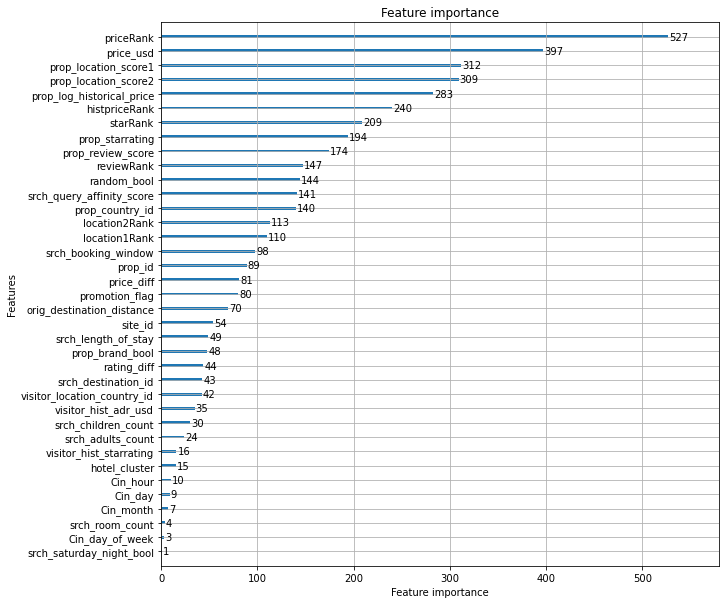

In [34]:
lgb.plot_importance(model2, figsize=(10,10))

In [1]:
evaluation_lgb = model2.evals_result_

NameError: name 'model2' is not defined

In [36]:
print(evaluation_lgb['valid_0']['ndcg@5'][-1])

0.8849734212673014


C:\Users\Quirijn\anaconda3\lib\site-packages\lightgbm\plotting.py:328: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='ndcg@5'>

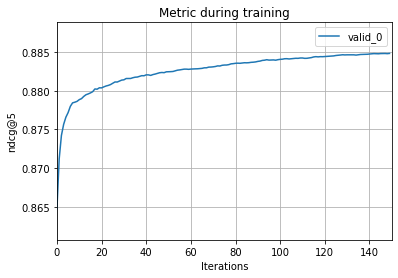

In [33]:
lgb.plot_metric(model2)

# XGBoost model

In [37]:
import xgboost as xgb

model3 = xgb.sklearn.XGBRanker(objective = 'rank:pairwise', learning_rate= 0.1,gamma= 1.0, min_child_weight= 0.1,
                                n_estimators= 200,subsample=0.7,max_depth=8,booster='gbtree')
#gbtree or dart
model3.fit(X_train, y_train, train_groups, eval_set=[(X_val, y_val)], eval_group=[val_groups],eval_metric = 'ndcg')

C:\Users\Quirijn\anaconda3\lib\site-packages\xgboost\core.py:430: FutureWarning: Pass `group` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning)


XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, gamma=1.0, gpu_id=-1,
          importance_type='gain', interaction_constraints='', learning_rate=0.1,
          max_delta_step=0, max_depth=8, min_child_weight=0.1, missing=nan,
          monotone_constraints='()', n_estimators=200, n_jobs=8,
          num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
          scale_pos_weight=None, subsample=0.7, tree_method='exact',
          validate_parameters=1, verbosity=None)

In [39]:
evaluation_xgb = model3.evals_result_

{'validation_0': OrderedDict([('ndcg',
               [0.887895,
                0.889298,
                0.890449,
                0.891487,
                0.891863,
                0.892409,
                0.892703,
                0.892898,
                0.893175,
                0.893314,
                0.89352,
                0.893715,
                0.893863,
                0.893973,
                0.894258,
                0.894422,
                0.894572,
                0.894696,
                0.894747,
                0.894822,
                0.894922,
                0.895038,
                0.895188,
                0.895161,
                0.895208,
                0.895293,
                0.895412,
                0.895522,
                0.895626,
                0.895694,
                0.895864,
                0.89588,
                0.895918,
                0.896121,
                0.896155,
                0.896194,
                0.896257,
 

In [40]:
print(evaluation_xgb['validation_0']['ndcg'][-1])

0.899262


In [ ]:
from matplotlib import pyplot
# plot learning curves
pyplot.plot(evaluation_xgb['validation_0']['ndcg'], label='train')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Preparing the test data

In [3]:
#test_data = pd.read_csv('test_set_VU_DM.csv') 

NameError: name 'pd' is not defined

In [ ]:
test_data['date_time'] = pd.to_datetime(test_data['date_time'])

test_data['Cin_hour'] = test_data["date_time"].apply(lambda x: x.hour)
test_data['Cin_day'] = test_data["date_time"].apply(lambda x: x.day)
test_data['Cin_month'] = test_data["date_time"].apply(lambda x: x.month)
test_data['Cin_quarter'] = test_data["date_time"].apply(lambda x: x.quarter)
test_data['Cin_day_of_week'] = test_data['date_time'].dt.dayofweek+1 #we don't want zeros

test_data.drop('date_time',axis=1,inplace=True)

In [ ]:
test_data['priceRank'] = test_data.groupby('srch_id')['price_usd'].rank()
test_data['starRank'] = test_data.groupby('srch_id')['prop_starrating'].rank()
test_data['reviewRank'] = test_data.groupby('srch_id')['prop_review_score'].rank()
test_data['location1Rank'] = test_data.groupby('srch_id')['prop_location_score1'].rank()
test_data['location2Rank'] = test_data.groupby('srch_id')['prop_location_score2'].rank()
test_data['histpriceRank'] = test_data.groupby('srch_id')['prop_log_historical_price'].rank()

In [ ]:
test_data['rating_diff']=abs(test_data['visitor_hist_starrating']-test_data['prop_starrating'])
test_data['rating_diff']=test_data['rating_diff'].fillna(test_data['rating_diff'].mean())

test_data['price_diff']=abs(test_data['visitor_hist_adr_usd']-test_data['price_usd'])
test_data['price_diff']=test_data['price_diff'].fillna(test_data['price_diff'].mean())

In [ ]:
test_data['competitor_rate'] = (test_data.comp1_rate + test_data.comp2_rate + test_data.comp3_rate +
                                test_data.comp4_rate + test_data.comp5_rate + test_data.comp6_rate +
                                test_data.comp7_rate + test_data.comp8_rate)

test_data['competitor_inv'] = (test_data.comp1_inv + test_data.comp2_inv + test_data.comp3_inv +
                               test_data.comp4_inv + test_data.comp5_inv + test_data.comp6_inv +
                               test_data.comp7_inv + test_data.comp8_inv)

test_data['competitor_rpd'] = (  test_data.comp1_rate_percent_diff + test_data.comp2_rate_percent_diff
                               + test_data.comp3_rate_percent_diff + test_data.comp4_rate_percent_diff
                               + test_data.comp5_rate_percent_diff + test_data.comp6_rate_percent_diff
                               + test_data.comp7_rate_percent_diff + test_data.comp8_rate_percent_diff)/8/100

test_data.drop('comp1_rate',axis=1,inplace=True)
test_data.drop('comp2_rate',axis=1,inplace=True)
test_data.drop('comp3_rate',axis=1,inplace=True)
test_data.drop('comp4_rate',axis=1,inplace=True)
test_data.drop('comp5_rate',axis=1,inplace=True)
test_data.drop('comp6_rate',axis=1,inplace=True)
test_data.drop('comp7_rate',axis=1,inplace=True)
test_data.drop('comp8_rate',axis=1,inplace=True)
test_data.drop('comp1_inv',axis=1,inplace=True)
test_data.drop('comp1_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp2_inv',axis=1,inplace=True)
test_data.drop('comp2_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp3_inv',axis=1,inplace=True)
test_data.drop('comp3_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp4_inv',axis=1,inplace=True)
test_data.drop('comp4_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp5_inv',axis=1,inplace=True)
test_data.drop('comp5_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp6_inv',axis=1,inplace=True)
test_data.drop('comp6_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp7_inv',axis=1,inplace=True)
test_data.drop('comp7_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp8_inv',axis=1,inplace=True)
test_data.drop('comp8_rate_percent_diff',axis=1,inplace=True)

In [ ]:
test_data = test_data[test_data.price_usd < 1800]

In [ ]:
test_data = test_data.fillna(0)

In [ ]:
clustering_kmeans = MiniBatchKMeans(n_clusters=100)
test_data['hotel_cluster'] = clustering_kmeans.fit_predict(test_data)

In [ ]:
test_data = test_data.sort_values('srch_id')
test_data = test_data.reset_index(drop =True)
test_data_search_ids = test_data.srch_id

test_data_groups = test_data.srch_id.value_counts(sort=True,ascending=True).sort_index()

srch_id = test_data.srch_id
prop_id = test_data.prop_id
test_data.drop(['srch_id'],axis=1,inplace=True)

In [ ]:
def create_result(rankings,srch_id,prop_id):
    predictions = pd.DataFrame(rankings,columns=['probs'])
    predictions = predictions.join(srch_id)
    predictions = predictions.join(prop_id)
    final_table = predictions.sort_values(by=['srch_id', 'probs'], ascending=[True, False])
    final_table.reset_index(drop = True, inplace = True)
    final_table = final_table.drop('probs',axis =1)
    
    return(final_table)

# Method 1 - LightGBM

In [2]:
#rankings_lgb = model2.predict(test_data)

'rankings_lgb = model2.predict(test_data)'

In [ ]:
#final_table_lgb2 = create_result(rankings_lgb,srch_id,prop_id)
#final_table_lgb2.to_csv('rankings_lgb_cluster_booking3.csv',index = False)

# Method 2 - XGBoost

In [ ]:
#rankings_xgb = model3.predict(test_data)

In [ ]:
#final_table_xgb = create_result(rankings_xgb,srch_id,prop_id)
#final_table_xgb.to_csv('rankings_xgb_cluster_booking1.csv',index = False)

Compare LGB with XGB

In [ ]:
#table = pd.DataFrame()
#table['srch_id'] = srch_id
#table['prob_id_lgb'] = final_table_lgb2['prop_id']
#table['prob_id_xgb'] = final_table_xgb['prop_id']
#print(table)